In [13]:
# import necessary packages
import plotly.graph_objects as go
import pandas as pd
import plotly.express as px

In [ ]:
# load data

df = pd.read_csv("nodes-entities.csv", usecols=["countries", "jurisdiction_description"], low_memory=False)
df.head()

In [19]:
# clean data 

df["countries"] = df["countries"].fillna("").astype(str)

df = df[df["countries"] != ""]

df["countries"] = df["countries"].str.split(";")

df = df.explode("countries")

df["countries"] = df["countries"].str.strip()

df = df[df["countries"].str.lower() != "not identified"]
df = df[df["countries"] != ""]
df = df[df["jurisdiction_description"].str.strip().str.lower() != "undetermined"]

In [22]:
top_jurisdictions = (
    df["jurisdiction_description"]
    .value_counts()
    .nlargest(5)
    .index
    .tolist()
)

df_filtered = df[df["jurisdiction_description"].isin(top_jurisdictions)].copy()

In [23]:
print(top_jurisdictions)

['British Virgin Islands', 'Malta', 'Panama', 'Barbados', 'Bahamas']


In [25]:
flow_counts = (
    df_filtered
    .groupby(["countries", "jurisdiction_description"])
    .size()
    .reset_index(name="count")
)

top_origins = (
    flow_counts
    .groupby("countries")["count"]
    .sum()
    .nlargest(10)
    .index
    .tolist()
)

flow_counts = flow_counts[flow_counts["countries"].isin(top_origins)].copy()

In [28]:
labels = top_origins + [j for j in top_jurisdictions if j not in top_origins]
label_to_index = {label: i for i, label in enumerate(labels)}

flow_counts["source"] = flow_counts["countries"].map(label_to_index)
flow_counts["target"] = flow_counts["jurisdiction_description"].map(label_to_index)

palette = px.colors.qualitative.Plotly
origin_color_map = {origin: palette[i % len(palette)] for i, origin in enumerate(top_origins)}
flow_counts["link_color"] = flow_counts["countries"].map(origin_color_map)

In [30]:
node_colors = [origin_color_map.get(lbl, "lightgray") for lbl in labels]

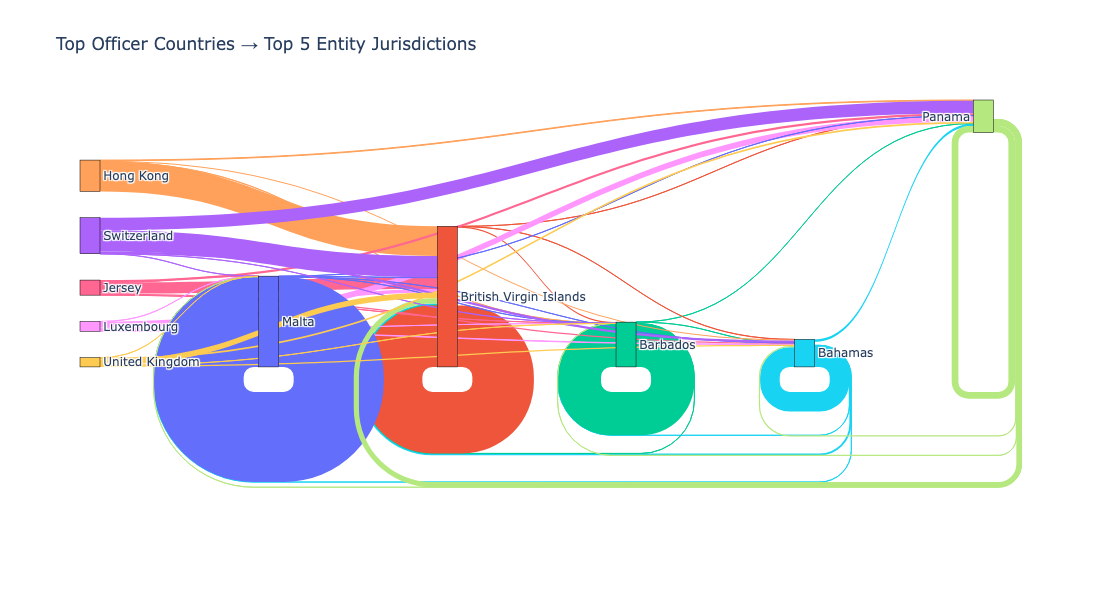

In [35]:
colors = px.colors.qualitative.Plotly

fig = go.Figure(
    data=[
        go.Sankey(
            node=dict(
                pad=15,
                thickness=20,
                line=dict(color="black", width=0.5),
                label=labels,
                color=node_colors,
            ),
            link=dict(
                source=flow_counts["source"],
                target=flow_counts["target"],
                value=flow_counts["count"],
                color=flow_counts["link_color"],
            ),
        )
    ]
)

fig.update_layout(
    title_text="Top Officer Countries → Top 5 Entity Jurisdictions",
    font=dict(size=12),
    height=600,
    width=1000,
)

fig.show()

In [34]:
flow_counts["proportion"] = (
    flow_counts.groupby("countries")["count"]
               .transform(lambda x: x / x.sum())
)

flow_table = (
    flow_counts[["countries", "jurisdiction_description", "count", "proportion"]]
    .sort_values(["countries", "count"], ascending=[True, False])
    .reset_index(drop=True)
)

print(flow_table)

                 countries jurisdiction_description  count  proportion
0                  Bahamas                  Bahamas  18257    0.817673
1                  Bahamas                   Panama   2256    0.101039
2                  Bahamas   British Virgin Islands   1764    0.079004
3                  Bahamas                 Barbados     50    0.002239
4                  Bahamas                    Malta      1    0.000045
5                 Barbados                 Barbados  40282    0.999132
6                 Barbados                   Panama     18    0.000446
7                 Barbados   British Virgin Islands     15    0.000372
8                 Barbados                  Bahamas      2    0.000050
9   British Virgin Islands   British Virgin Islands  57170    0.977917
10  British Virgin Islands                 Barbados   1053    0.018012
11  British Virgin Islands                  Bahamas    145    0.002480
12  British Virgin Islands                   Panama     93    0.001591
13    